In [11]:
# Cell 1
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from tqdm import tqdm



In [23]:
# Cell 2 (updated)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, min(num_files_to_use, len(svc_files)))

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    max_length = 0
    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)
        max_length = max(max_length, len(df))

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    # Pad sequences to max_length
    padded_data = []
    for df, scaler in zip(data_frames, scalers):
        normalized = np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values))
        padded = np.pad(normalized, ((0, max_length - len(normalized)), (0, 0)), mode='constant', constant_values=0)
        padded_data.append(padded)

    combined_data = np.array(padded_data)

    return data_frames, combined_data, scalers, max_length

In [24]:
# Cell 3 (updated)
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.beta = beta
        
        # Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        _, (h, _) = self.encoder(x)
        h = h[-1]  # Use the last layer's hidden state
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, length):
        z_repeated = z.unsqueeze(1).repeat(1, length, 1)
        output, _ = self.decoder(z_repeated)
        return self.output_layer(output)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, x.size(1)), mu, logvar

# Cell 4 (unchanged)
class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(lstm_out[:, -1, :]))  # Use the last time step output

In [25]:


# Cell 5 (updated)
def train_gan(generator, discriminator, dataloader, num_epochs, batch_size, latent_dim, device):
    generator.to(device)
    discriminator.to(device)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
    
    criterion = nn.BCELoss()
    
    for epoch in range(num_epochs):
        for i, (real_data, _) in enumerate(dataloader):
            batch_size = real_data.size(0)
            real_data = real_data.to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            
            # Real data
            real_labels = torch.ones(batch_size, 1).to(device)
            real_output = discriminator(real_data)
            d_loss_real = criterion(real_output, real_labels)
            
            # Fake data
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data, _, _ = generator(real_data)  # Use real_data to get the correct sequence length
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_output = discriminator(fake_data.detach())
            d_loss_fake = criterion(fake_output, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            
            fake_data, mu, logvar = generator(real_data)
            fake_output = discriminator(fake_data)
            
            g_loss = criterion(fake_output, real_labels)
            
            # Add VAE loss
            recon_loss = nn.MSELoss()(fake_data, real_data)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            vae_loss = recon_loss + generator.beta * kl_div
            
            total_loss = g_loss + vae_loss
            total_loss.backward()
            optimizer_G.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, VAE Loss: {vae_loss.item():.4f}")
    
    return generator, discriminator

# Cell 6 (updated)
def generate_augmented_data(generator, num_samples, latent_dim, max_length, device):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        augmented_data = generator.decode(z, max_length)
    return augmented_data.cpu().numpy()

# Cell 7
def plot_augmented_data(augmented_data, scalers):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Inverse transform the data
    original_scale_data = np.vstack([scaler.inverse_transform(augmented_data[:, :2]) for scaler in scalers])
    
    # Separate on-paper and in-air points
    on_paper = original_scale_data[augmented_data[:, 2] >= 0.5]
    in_air = original_scale_data[augmented_data[:, 2] < 0.5]
    
    ax.scatter(-on_paper[:, 1], on_paper[:, 0], c='blue', s=1, alpha=0.7, label='On Paper')
    ax.scatter(-in_air[:, 1], in_air[:, 0], c='red', s=1, alpha=0.7, label='In Air')
    
    ax.set_title('Augmented Data')
    ax.set_xlabel('-y')
    ax.set_ylabel('x')
    ax.legend()
    ax.set_aspect('equal')
    
    plt.show()

C:\Users\annek\AppData\Local\Temp\ipykernel_7952\2368317334.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_7952\2368317334.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_7952\2368317334.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_7952\2368317334.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecat

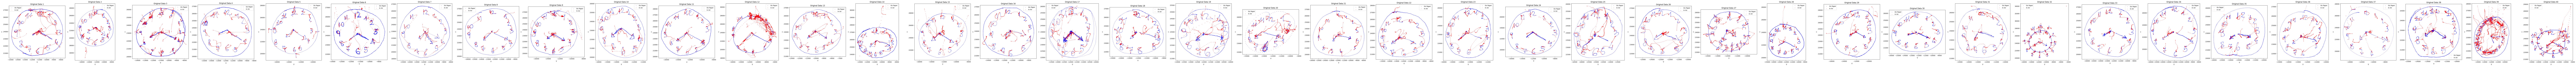

Processed data shape: (40, 11541, 3)
Max sequence length: 11541


: 

In [27]:
# Cell 8 (updated)
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and process data
    directory = 'Task6'  # Update this to your directory path
    data_frames, combined_data, scalers, max_length = upload_and_process_files(directory, num_files_to_use=40)
    print(f"Processed data shape: {combined_data.shape}")
    print(f"Max sequence length: {max_length}")
    
    # Prepare data for PyTorch
    tensor_data = torch.FloatTensor(combined_data)
    dataset = TensorDataset(tensor_data, torch.zeros(tensor_data.size(0)))  # Dummy labels
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    # Initialize models
    input_dim = 3  # x, y, pen_status
    hidden_dim = 64
    latent_dim = 32
    beta = 1.0
    
    generator = VAE(input_dim, hidden_dim, latent_dim, beta)
    discriminator = LSTMDiscriminator(input_dim, hidden_dim, num_layers=2)
    
    # Train GAN
    num_epochs = 100
    generator, discriminator = train_gan(generator, discriminator, dataloader, num_epochs, 32, latent_dim, device)
    
    # Generate augmented data
    num_augmented_samples = 1000  # You can change this to generate more or fewer samples
    augmented_data = generate_augmented_data(generator, num_augmented_samples, latent_dim, max_length, device)
    
    # Post-process augmented data
    augmented_data[:, :, 2] = (augmented_data[:, :, 2] >= 0.5).astype(float)  # Binarize pen_status
    
    # Plot augmented data
    plot_augmented_data(augmented_data.reshape(-1, 3), scalers)